In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [3]:
# Define the parameters
resolution = 4
attributes = ['aggressiveness', 'sentiment', 'stance']
days_before_after = [7, 14, 21, 28]
metrics_df = pd.DataFrame(columns=['Attribute', 'Days Before', 'Days After', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [ ]:
# Loop over each attribute and each combination of days before and after
for attribute in attributes:
    for days_before in days_before_after:
        for days_after in days_before_after:
            # Load the data
            df = pd.read_csv(f'training_data_{resolution}deg/training_data_{resolution}deg_{attribute}_{days_before}db_{days_after}da.csv')

            # Exclude 'no_change' instances
            df = df[df['no_change'] != 1]

            # Separate features and target variables
            X = df.drop(['negative_change', 'no_change', 'positive_change'], axis=1)
            y = df['positive_change'] # Now y directly corresponds to whether there is a positive change or not

            # Normalize the features to [0, 1] range
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)

            # Split the data into training, validation and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

            # Define the model
            model = Sequential()
            model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(512, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1, activation='sigmoid')) # Changed to sigmoid activation

            # Compile the model
            model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy']) # Change the loss to binary_crossentropy

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

            # Save the model
            save_model(model, f'models_{resolution}deg/model_{resolution}deg_{attribute}_{days_before}db_{days_after}da.h5')

            # Predict on test data
            y_pred = model.predict(X_test)
            y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

            # Calculate performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Append to the dataframe
            new_row = pd.DataFrame({
                'Attribute': [attribute],
                'Days Before': [days_before],
                'Days After': [days_after],
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1 Score': [f1]
            })
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [ ]:
# Save the metrics to a csv file
metrics_df.to_csv(f'model_performance_metrics_{resolution}deg.csv', index=False)

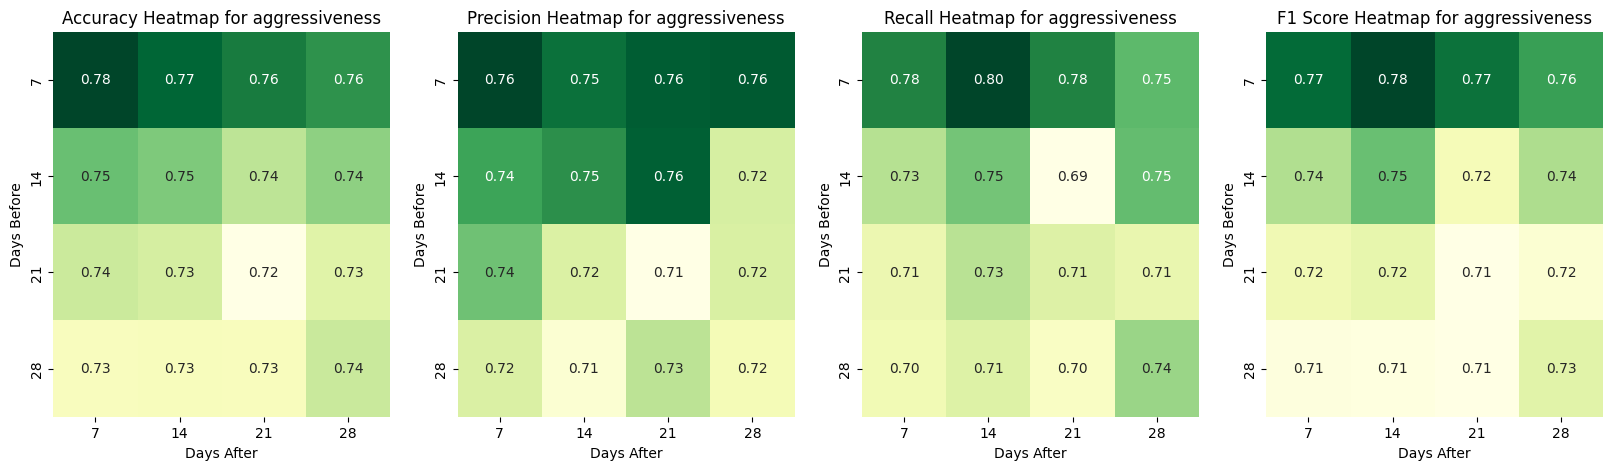

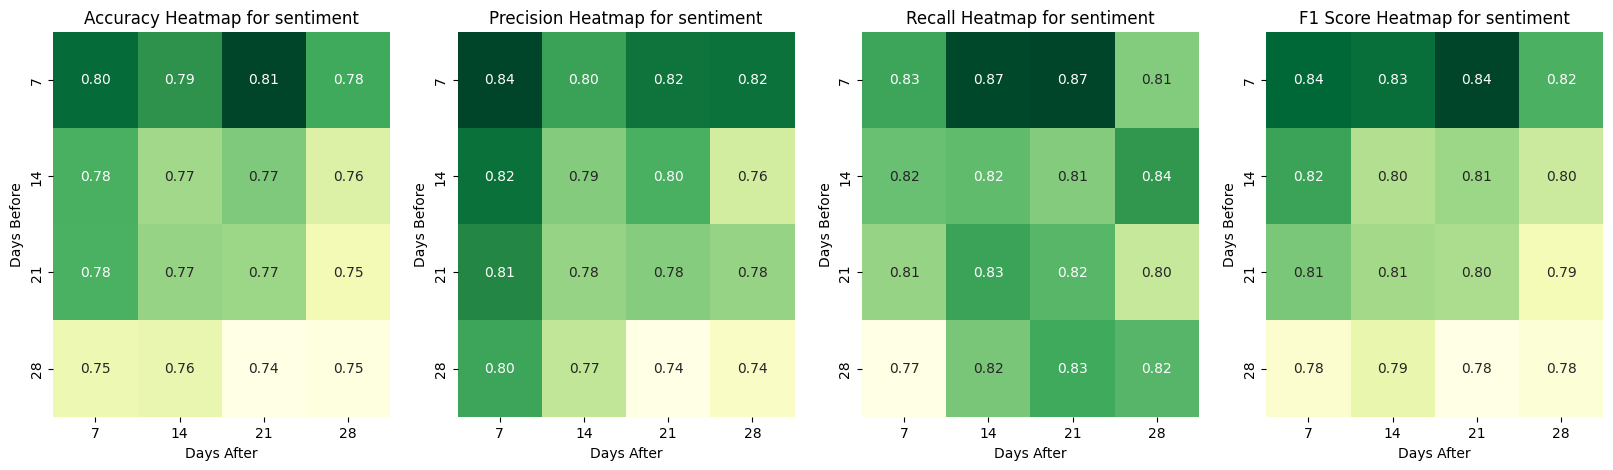

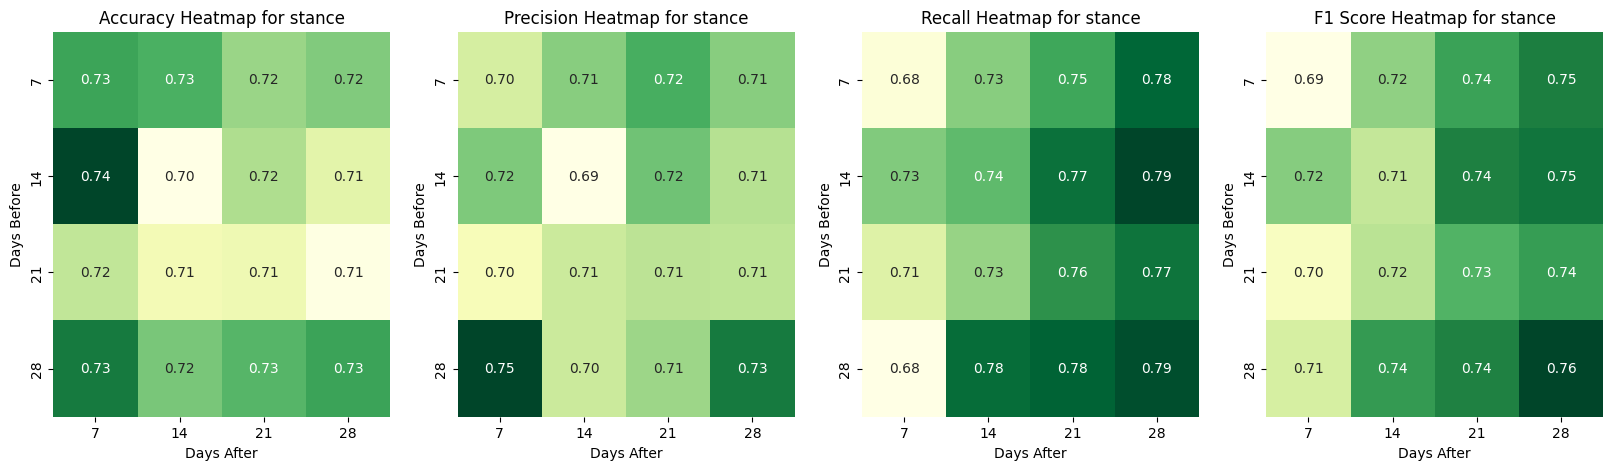

In [4]:
# Visualizing the performance
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

metrics_df = pd.read_csv(f'model_performance_metrics_{resolution}deg.csv')

for attribute in attributes:
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, metric in enumerate(metrics_list):
        attribute_metrics = metrics_df[metrics_df['Attribute'] == attribute].copy()
        attribute_metrics['Days Before'] = attribute_metrics['Days Before'].astype(int)
        attribute_metrics['Days After'] = attribute_metrics['Days After'].astype(int)
        pivoted_data = attribute_metrics.pivot(index='Days Before', columns='Days After', values=metric)
        sns.heatmap(pivoted_data, annot=True, cmap='YlGn', cbar=False, fmt=".2f", xticklabels=pivoted_data.columns, yticklabels=pivoted_data.index, ax=axs[i])
        axs[i].set_title(f'{metric} Heatmap for {attribute}')
        axs[i].set_xlabel('Days After')
        axs[i].set_ylabel('Days Before')
    plt.show()